# Часть 0

### Подключимся к приложению

In [1]:
import os
import isodate
from pprint import pprint
import google_auth_oauthlib.flow
import googleapiclient.discovery
import googleapiclient.errors


In [2]:
client_secrets_file = "client_secret.json.json"

In [3]:
scopes = ["https://www.googleapis.com/auth/youtube.readonly", 'https://www.googleapis.com/auth/youtube.force-ssl']

In [4]:
os.environ["OAUTHLIB_INSECURE_TRANSPORT"] = "1"

In [5]:
api_service_name = "youtube"
api_version = "v3"
client_secrets_file = "client_secret.json"

flow = google_auth_oauthlib.flow.InstalledAppFlow.from_client_secrets_file(client_secrets_file, scopes)
credentials = flow.run_console()
youtube = googleapiclient.discovery.build(api_service_name, api_version, credentials=credentials)

Please visit this URL to authorize this application: https://accounts.google.com/o/oauth2/auth?response_type=code&client_id=554521698307-vnhq5jei3ie56hdpuegl2rei60mkebb9.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fyoutube.readonly+https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fyoutube.force-ssl&state=yKywLLTFac7Ra5zFlfa87L6TtEw7kD&prompt=consent&access_type=offline
Enter the authorization code: 4/zQGjNdfj16wTHrDejH12FaWBbEJ0a9LbbkQ9ivXoux_Qu9opKRtGsB4


# Часть 1 

Сначала достанем ссылку на канал

In [6]:
request = youtube.channels().list(
    part="contentDetails",
    id="UCluKJdAf2X7d721bpL6XkWQ"
)
response = request.execute()

In [7]:
url = response['items'][0]['contentDetails']['relatedPlaylists']['uploads']

Теперь нам нужна итерация по страницам

In [8]:
next_page_token = ''
video_ids = []  #  id видео
for token in range(6):
    request = youtube.playlistItems().list(
    part="contentDetails",
    playlistId= url,
    maxResults=50,
    pageToken = next_page_token
    )
    
    response = request.execute()
    for i in range(len(response['items'])):
        video = (response['items'][i]['contentDetails']['videoId'])
        video_ids.append(video)
    
    next_page_token = response['nextPageToken']  


In [9]:
len(set(video_ids))  #  убедимся, что мы достали > 250 уникальных id видео 

300

Достанем метаинформацию, сначала посмотрим без итерации, как что достать 

In [10]:
request = youtube.videos().list(
    part="statistics",
    id=video_ids[0]
)
response = request.execute()


In [11]:
response['items'][0]['statistics']['viewCount']  #  просмотры

'21677'

In [12]:
response['items'][0]['statistics']['likeCount']  #  лайки 

'3212'

In [13]:
response['items'][0]['statistics']['dislikeCount']  #  дизлайки 

'19'

In [14]:
response['items'][0]['statistics']['commentCount']  #  количество комментов

'151'

In [15]:
# заголовок
request = youtube.videos().list(
    part="snippet",
    id=video_ids[-1]
)
response = request.execute()
pprint(response['items'][0]['snippet']['localized']['title'])

'Философия - Иммануил Кант [The School of Life]'


In [16]:
#  дата публикации
import datetime
from datetime import date
a = response['items'][0]['snippet']['publishedAt'][0:10]
a

'2018-12-31'

In [17]:
# язык аудио по умолчанию

response['items'][0]['snippet']['defaultAudioLanguage']

'ru'

In [18]:
request = youtube.videos().list(
    part="contentDetails",
    id=video_ids[0]
)
response = request.execute()


In [19]:
# достанем длину видео
a = response['items'][0]['contentDetails']['duration']  

In [20]:
# переведем в секунды
date = isodate.parse_duration(a)  
seconds = date.seconds
seconds

197

### Запишем все в цикл 

In [21]:
views, likes, dislikes= [], [], []
comments, times, lang = [], [], []
title, piblished_time = [], []


In [22]:
import time
import tqdm

In [23]:
s = 0  #  счетчик
while s < len(video_ids):
    for i in range(len(video_ids)):
        request = youtube.videos().list(
        part="statistics",
        id=video_ids[s]
        )
        response = request.execute()
        #time.sleep(1)
        
        views.append(response['items'][0]['statistics']['viewCount'])
        likes.append(response['items'][0]['statistics']['likeCount'])
        dislikes.append(response['items'][0]['statistics']['dislikeCount'])
        comments.append(response['items'][0]['statistics']['commentCount'])

        request = youtube.videos().list(
        part="contentDetails",
        id=video_ids[s]
        )
        response = request.execute()  
        a = response['items'][0]['contentDetails']['duration'] 
        date = isodate.parse_duration(a)  
        seconds = date.seconds
        times.append(seconds)
        
        request = youtube.videos().list(
        part="snippet",
        id=video_ids[s]
        )
        response = request.execute() 
        lang.append(response['items'][0]['snippet']['defaultAudioLanguage'])
        title.append(response['items'][0]['snippet']['localized']['title'])
        piblished_time.append(response['items'][0]['snippet']['publishedAt'][0:10])
        
        s += 1
        

# Часть 2

### создадим базу данных 

In [24]:
import sqlite3

In [25]:
db = sqlite3.connect('Youtube_p2.db')
cur = db.cursor()

In [26]:
cur.execute("""
CREATE TABLE tags (
    id INTEGER PRIMARY KEY AUTOINCREMENT,
    tag    TEXT
);
""")

cur.execute("""
CREATE TABLE video_to_tags (
    id_video    INTEGER,
    id_tag    INTEGER
);
""")

cur.execute("""
CREATE TABLE video_meta (
    id INTEGER PRIMARY KEY AUTOINCREMENT,
    youtube_id    TEXT,
    likeCount INT,
    dislikeCount INT,
    commentCount INT,
    viewCount INT,
    defaultAudioLanguage TEXT,
    title TEXT,
    duration INT,
    published_time INT
);
""")

cur.execute("""
CREATE TABLE comments (
    id_com INTEGER PRIMARY KEY AUTOINCREMENT,
    author_id TEXT,
    author_name TEXT,
    likeCount INT,
    text_of_comment TEXT,
    publ_data TEXT,
    upd_data TEXT,
    replyCount INT
);
""")

db.commit()

# Часть 3

### Заполним базу данных

Сначала заполним таблицу video_meta с метаданными по видео

In [27]:
vide = range(1 ,len(likes) + 1)  #  нужно для id

In [28]:
import pandas as pd

df1 = pd.DataFrame({
    'id' : vide,
    'video': video_ids,
    'likes' : likes,
    'dislikes': dislikes,
    'comments': comments,
    'views' : views,
    'lang': lang,
    'title' : title,
    'times' : times,
    'published_time' : piblished_time
                  })
df1.head(2)

,id,video,likes,dislikes,comments,views,lang,title,times,published_time
0,1,P1dGjaNxFqk,3212,19,151,21677,ru,"Люби меня таким, какой я есть",197,2020-04-28
1,2,1K5C9aYZFZI,853,19,33,11876,ru,"Почему Вы должны прочитать ""Клуб радости и уда...",252,2020-04-24


In [29]:
df1.to_sql( 'video_meta' , db, if_exists='replace', index = False)
cur.execute('''  
SELECT * FROM video_meta
          ''')
db.commit()

Теперь заполним таблицы tags, video_to_tags, sqlite_sequence

In [30]:
cur.execute('SELECT video, id FROM video_meta')
videos = {key: val for key, val in cur.fetchall()}

In [31]:
cur.execute('SELECT tag, id FROM tags')
tags = {key: val for key, val in cur.fetchall()}
t_idx = 0 if len(tags) == 0 else max(tags.values())

tags_to_insert = []
for vid in video_ids:
    request = youtube.videos().list(
        part="snippet",
        id=vid
    )
    response = request.execute()
    snippet = response.get('items', [0])[0].get('snippet', {})
    these_tags = snippet.get('tags')
    save_tags = []
    for t in these_tags:
        if t not in tags:
            tags[t] = t_idx + 1
            t_idx = t_idx + 1
            tags_to_insert.append((t_idx, t))
        save_tags.append((videos[vid], tags[t]))
    cur.executemany("INSERT INTO video_to_tags VALUES (?, ?)", save_tags)
cur.executemany("INSERT INTO tags VALUES (?, ?)", tags_to_insert)
db.commit()

# Часть 4

### Визуализация по видео. График 1. WordCloud

Достанем теги из базы данных, преобразуем в нужный формат и удалим лишние знаки

In [32]:
from collections import Counter

In [33]:
tags_all = [ ]

for row in cur.execute('SELECT tag FROM tags'):
    tags_all.append(str(row).replace(')', '').replace('(', '').replace('(', '').replace("'", '').replace(",", ''))

In [34]:
a = Counter(tags_all)

Построим вордклауд по тегам

In [35]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

wordcloud = WordCloud(background_color='white').fit_words(a)
# отобразим вордклауд
plt.figure(figsize=(10,10))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()


<Figure size 1000x1000 with 1 Axes>

### Визуализация по видео. График 2. 

### Построим график зависимости количества просмотров от времени

In [36]:
import numpy as np
import seaborn as sns

In [37]:
years = []
for row in cur.execute('SELECT published_time FROM video_meta'):
    years.append(row[0])


Создадим датафрейм, чтобы можно было по простому доставать метаданные и конвертировать их 

In [38]:
df2 = pd.DataFrame({
    'views' : views,
    'likes' : likes
                  })
df2.head(2)


,views,likes
0,21677,3212
1,11876,853


In [39]:
import datetime
from datetime import date

xdata = []  #  список со временем
ydata = []  #  список с лайками формата int
for y in years:
    q = y.split('-')
    xdata.append(date(int(q[0]), int(q[1]), int(q[2])))
for d in df2['views']:
    ydata.append(int(d))

/Users/mariadolgodvorova/opt/anaconda3/lib/python3.6/site-packages/pandas/plotting/_matplotlib/converter.py:103: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)
/Users/mariadolgodvorova/opt/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:24: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


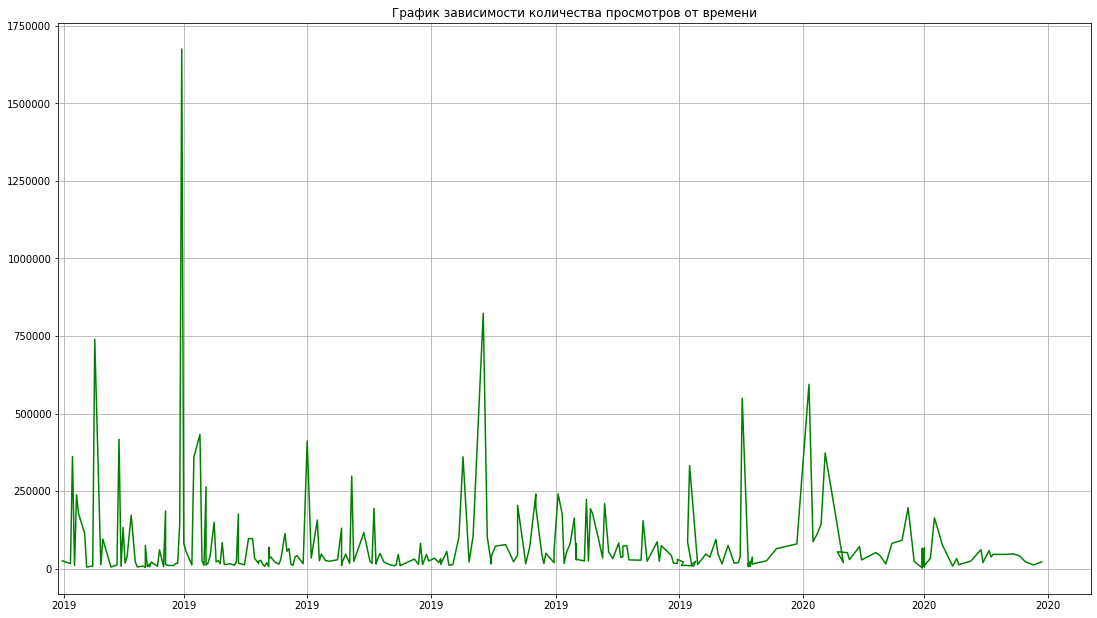

In [40]:
import pylab
import matplotlib.dates

# Преобразуем даты в числовой формат
xdata_float = matplotlib.dates.date2num(xdata)
# Вызовем subplot явно, чтобы получить экземпляр класса AxesSubplot
axes = pylab.subplot(1, 1, 1)
axes.xaxis.set_major_formatter(matplotlib.dates.DateFormatter("%Y"))
pylab.plot_date(xdata_float, ydata, 
                linestyle = "-",
                color = "g", 
                fmt="b-")

# в самом начале из списка с датами я взяла последний элемент - это 2018-12-29
# даты публикаций начинаются с 2018-12-29 и мы строим график с этой даты
pylab.xlim(xmin=matplotlib.dates.date2num(date(2018, 12, 29)))

pylab.title('График зависимости количества просмотров от времени')
pylab.grid()


fig = matplotlib.pyplot.gcf()
fig.set_size_inches(18.5, 10.5)
fig.show()

### Визуализация по видео. График 3. 

### Построим график зависимости количества лайков от времени

In [41]:
ldata = [] 
for l in df2['likes']:
    ldata.append(int(l))

/Users/mariadolgodvorova/opt/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:23: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


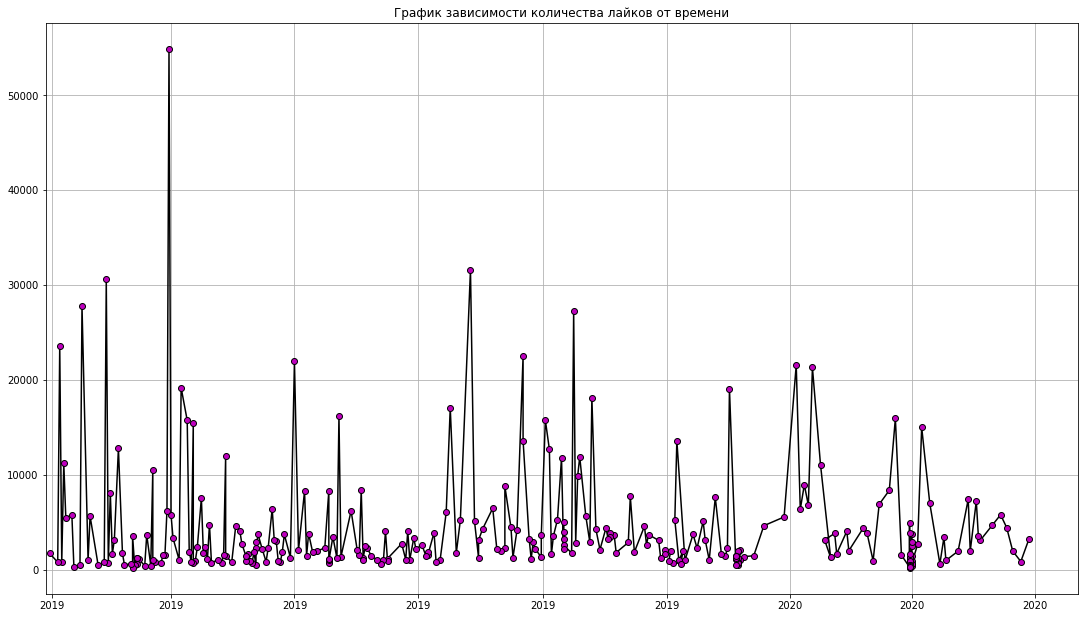

In [42]:
import pylab
import matplotlib.dates

# Преобразуем даты в числовой формат
xdata_float = matplotlib.dates.date2num(xdata)
# Вызовем subplot явно, чтобы получить экземпляр класса AxesSubplot
axes = pylab.subplot(1, 1, 1)
axes.xaxis.set_major_formatter(matplotlib.dates.DateFormatter("%Y"))
pylab.plot_date(xdata_float, ldata, 
    linestyle = "-", 
    marker = "o", 
    color = "k", 
    markerfacecolor = "m")

pylab.xlim(xmin=matplotlib.dates.date2num(date(2018, 12, 29)))


pylab.title('График зависимости количества лайков от времени')
pylab.grid()

fig = matplotlib.pyplot.gcf()
fig.set_size_inches(18.5, 10.5)
fig.show();

# Часть 5 

https://www.youtube.com/watch?v=4NRXx6U8ABQ - взяла в качестве "популярного международного видео", мне кажется, здесь должна быть интересная статистика по языкам

Сперва, как обычно, посмотрим без цикла, как достать информацию 

In [43]:
request = youtube.commentThreads().list(
    part="snippet",
    videoId="4NRXx6U8ABQ",
    maxResults=50
)
response = request.execute()

In [44]:
# следующая страница
response['nextPageToken']

'QURTSl9pMWRicGlOdnFlN3dteTZZMGdURV9HMHczdkRhdFNVcGw4aTNEcjhZWllMN2docUN0b0prZFlLTzZsaTNLajI3aTJyWmxobFZWUmwxTUtvcy1rZ2JkdTJsblFiN2NMUEVFckhwcEU0ZVJ6MTcwblJub003UXN5cEJjNmQ1aGs='

In [45]:
# id 
response['items'][0]['snippet']['topLevelComment']['id']

'Ugxdd4kRPpuVXMWSEft4AaABAg'

In [46]:
# имя оставившего комментарий
response['items'][0]['snippet']['topLevelComment']['snippet']['authorDisplayName']

'charliecoustic'

In [47]:
# количество лайков
response['items'][0]['snippet']['topLevelComment']['snippet']['likeCount']

0

In [48]:
# текст коммента
response['items'][0]['snippet']['topLevelComment']['snippet']['textDisplay']

'I wanted to hear the song clearly<br />His car: bruhhhhhhhhhhhh'

In [49]:
# дата публикации
response['items'][0]['snippet']['topLevelComment']['snippet']['publishedAt'][0:10]

'2020-04-29'

In [50]:
# дата апдейта
response['items'][0]['snippet']['topLevelComment']['snippet']['updatedAt'][0:10]

'2020-04-29'

In [51]:
# количество ответов
response['items'][0]['snippet']['totalReplyCount']

0

### Запишем все в цикл

In [52]:
next_page_token = ''

author_id = []  
author_name = []
likeCount = []
text_of_comment = []
publ_data = []
upd_data = []
replyCount = []


for token in range(20):
    request = youtube.commentThreads().list(
    part="snippet",
    videoId="4NRXx6U8ABQ",
    maxResults=50,
    pageToken = next_page_token
    )   
    response = request.execute()
    
    s = 0
    for i in range(len(response['items'])):
        author_id.append(response['items'][s]['snippet']['topLevelComment']['id'])
        author_name.append(response['items'][s]['snippet']['topLevelComment']['snippet']['authorDisplayName'])
        likeCount.append(response['items'][s]['snippet']['topLevelComment']['snippet']['likeCount'])
        text_of_comment.append(response['items'][s]['snippet']['topLevelComment']['snippet']['textDisplay'])
        publ_data.append(response['items'][s]['snippet']['topLevelComment']['snippet']['publishedAt'][0:10])
        upd_data.append(response['items'][s]['snippet']['topLevelComment']['snippet']['updatedAt'][0:10])
        replyCount.append(response['items'][s]['snippet']['totalReplyCount'])
        
        s += 1
    next_page_token = response['nextPageToken'] 

In [53]:
len(author_id)  #  убедимся, что комментов 1000

1000

# Часть 6

Дозапишем в базу данных комменты, удобнее сделать это, предварительно создав DataFrame

In [54]:
id_com = range(len(author_id))

In [55]:
df4 = pd.DataFrame({
    'id_com' : id_com,
    'author_id' : author_id,
    'author_name' : author_name,
    'likeCount' : likeCount,
    'text_of_comment' : text_of_comment,
    'publ_data' : publ_data,
    'upd_data' : upd_data,
    'replyCount' : replyCount
                  })
df4.head(2)

,id_com,author_id,author_name,likeCount,text_of_comment,publ_data,upd_data,replyCount
0,0,Ugxdd4kRPpuVXMWSEft4AaABAg,charliecoustic,0,I wanted to hear the song clearly<br />His car...,2020-04-29,2020-04-29,0
1,1,UgzopJsUzkUmJD3bhg94AaABAg,MISTA BRAILAN,0,im from shazam,2020-04-29,2020-04-29,0


In [56]:
df4.to_sql( 'comments' , db, if_exists='replace', index = False)
cur.execute('''  
SELECT * FROM comments
          ''')
db.commit()

# Часть 7

### Статистика по комментариям

In [57]:
#! pip install langdetect

In [67]:
com_text = []
like = []
for row in cur.execute('SELECT text_of_comment FROM comments'):
    com_text.append(row)
for row in cur.execute('SELECT likeCount FROM comments'):
    like.append(int(str(row).replace(')', '').replace('(', '').replace('(', '').replace("'", '').replace(",", ''))) 
  

In [68]:
reply = []
for row in cur.execute('SELECT replyCount FROM comments'):
    reply.append(int(str(row).replace(')', '').replace('(', '').replace('(', '').replace("'", '').replace(",", '')))

In [69]:
from langdetect import detect

In [76]:
languages = []
l_likes = []
smiles = []
length = []
s = 0

for i in com_text:
    try:
        languages.append(detect(str(i)))
        l_likes.append(like[s])
        length.append(len(str(i)))
        s+=1
    except Exception:  #  избежать ошибки, когда в весь коммент из смайликов
        smiles.append(str(i))
        s+=1
        

In [81]:
df_1 = pd.DataFrame({
    'lang' : languages,
    'likeCount' : l_likes,
    'leng' : length
                  })
df_1.head(2)

,lang,likeCount,leng
0,en,0,68
1,en,0,19


### График 4

### Посмотрим на встречаемость языков в комментариях

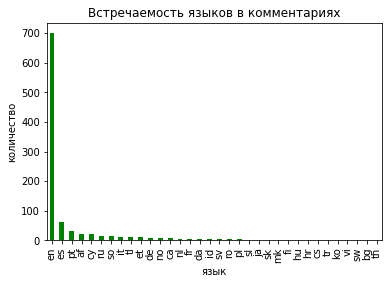

In [92]:
df_1['lang'].value_counts().plot.bar(color='green'); # барплот сразу из датафрейма
plt.title('Встречаемость языков в комментариях')
plt.xlabel('язык')
plt.ylabel('количество комментариев');

### График 5

Посмотрим на длину комментариев в разных языках

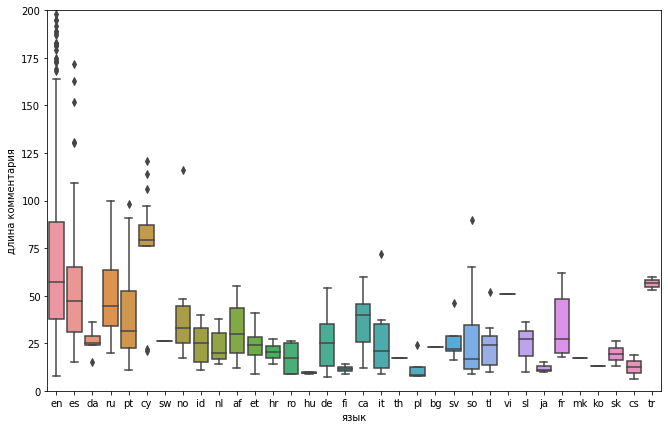

In [111]:
plt.figure(figsize=(11, 7))
sns.boxplot(x="lang", y="leng", data=df_1)
plt.ylim((0, 200))
plt.ylabel('длина комментария')
plt.xlabel('язык');